In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
from scipy.signal import savgol_filter
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Fonctions utilisées dans ce projet 

In [3]:
## Appliquons la snv à notre array intensities et visualisons 
def snv_spectrum(spectrum):
    mean = np.mean(spectrum)  # Calcul de la moyenne du spectre
    std_dev = np.std(spectrum)  # Calcul de l'écart type du spectre
    snv_spectrum = (spectrum - mean) / std_dev  # Transformation SNV
    return snv_spectrum

def plot_acp_individuals(score, plan_indices, class_labels, explained_variance, individual_names=None):
    """
    Affiche la carte factorielle des individus d'une ACP.

    Args:
        score (array): Les scores (coordonnées des individus) de l'ACP.
        plan_indices (tuple): Les indices des composantes principales à afficher (par exemple, (0, 1) pour le plan 2D).
        class_labels (array): Les classes à utiliser pour colorier les individus.
        explained_variance (array): La variance expliquée par chaque composante principale de l'ACP.
        individual_names (array, facultatif): Les noms des individus (ou labels). Par défaut, None.
    """

    # Extraire les indices des composantes principales à afficher
    component1_index, component2_index = plan_indices

    # Plotter la carte factorielle des individus
    plt.figure(figsize=(16, 9))
    for label in set(class_labels):
        mask = (class_labels == label)
        plt.scatter(score[mask, component1_index], score[mask, component2_index], label=label)

    # Ajouter des labels aux points (en vérifiant si le nom est différent de None)
    if individual_names is not None:
        for i, name in enumerate(individual_names):
            if name is not None:
                plt.annotate(name, (score[i, component1_index], score[i, component2_index]))

    # Afficher la variance expliquée par chaque composante dans le titre du graphique
    plt.title('Carte Factorielle des Individus\n' + '\n'.join([f'Composante {i+1}: {explained_variance[i]:.2%}' for i in plan_indices]))
    plt.xlabel(f'Composante Principale {component1_index + 1}')
    plt.ylabel(f'Composante Principale {component2_index + 1}')
    plt.legend()
    plt.grid(True, axis='both')
    plt.show()

# Exemple d'utilisation de la fonction avec individual_names facultatif
# Vous pouvez fournir ou omettre individual_names en fonction de vos besoins.
# plot_acp_individuals(score, (0, 1), class_labels, explained_variance)
# plot_acp_individuals(score, (0, 1), class_labels, explained_variance, individual_names)



def plot_dendrogram(model, **kwargs):
    """
    Plot a dendrogram based on a hierarchical clustering model.

    Args:
        model (AgglomerativeClustering): The hierarchical clustering model.
        **kwargs: Additional keyword arguments for customizing the dendrogram plot.
    """
    # Create an array to store the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    # Calculate counts for each node in the hierarchical tree
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Create a linkage matrix containing children, distances, and counts
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the dendrogram using the linkage matrix and custom kwargs
    dendrogram(linkage_matrix, **kwargs)


# Partie 1 : Exercice de reproduction 

## 1 Description du projet 

A partir du jeu de donnees d’analyses des terephtalates utilise dans le cours, vous allez realiser une r egression simple et une regression multiple.

## 2 Dans x tereph.tab selectionnez la quarantieme longueur d’onde du tableau, qu’on notera NIR40, et calculez le coefficient de corr ́elation et les coefficients du mod`ele de r ́egression lineaire de la variable densite en fonction de NIR40.

In [4]:
# importer les données 
x_tereph = pd.read_csv('data/x_tereph.csv')
y_tereph = pd.read_csv('data/y_tereph.csv')

In [5]:
x_tereph.head()

,\,NIR.1,NIR.2,NIR.3,NIR.4,NIR.5,NIR.6,NIR.7,NIR.8,NIR.9,...,NIR.259,NIR.260,NIR.261,NIR.262,NIR.263,NIR.264,NIR.265,NIR.266,NIR.267,NIR.268
0,1,3.0663,3.0861,3.1079,3.0972,2.9979,2.8273,2.6233,2.4039,2.1931,...,0.31308,0.30753,0.30313,0.29980,0.29748,0.29592,0.29489,0.29440,0.29432,0.29443
1,2,3.0675,3.0857,3.0958,3.0692,2.9818,2.8408,2.6760,2.5059,2.3506,...,0.31686,0.31195,0.30806,0.30499,0.30283,0.30149,0.30066,0.30031,0.30030,0.30041
2,3,3.0750,3.0966,3.0916,3.0288,2.8849,2.6885,2.4764,2.2694,2.0824,...,0.34026,0.33545,0.33164,0.32891,0.32703,0.32573,0.32493,0.32464,0.32460,0.32474
3,4,3.0828,3.0973,3.1010,3.0735,2.9913,2.8709,2.7392,2.6102,2.5000,...,0.32389,0.31947,0.31605,0.31332,0.31139,0.31023,0.30955,0.30928,0.30932,0.30947
4,5,3.1029,3.1034,3.0848,3.0228,2.8927,2.7159,2.5384,2.3764,2.2397,...,0.32394,0.31977,0.31649,0.31397,0.31218,0.31108,0.31046,0.31021,0.31026,0.31049


In [6]:
y_tereph.head()

,\,density
0,1,100.00
1,2,80.22
2,3,79.49
3,4,60.80
4,5,59.97


In [7]:
nir_40 = x_tereph['NIR.40'].values
density = y_tereph['density'].values

In [8]:
nir_40

array([1.4571, 1.5239, 1.546 , 1.5877, 1.5931, 1.5724, 1.6892, 1.6537,
       1.6884, 1.645 , 1.7041, 1.6996, 1.7063, 1.7041, 1.7121, 1.7549,
       1.7654, 1.754 , 1.744 , 1.7343, 1.7518])

In [9]:
density

array([100.  ,  80.22,  79.49,  60.8 ,  59.97,  60.48,  40.1 ,  40.  ,
        41.22,  41.16,  20.53,  20.35,  20.33,  20.61,  20.76,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ])

In [10]:
## Calculons la corrélation entre les deux variables 
cor = np.corrcoef(nir_40 , density)
print( " La corrélation entre NIR40 et la densité est ", cor[0,1])

 La corrélation entre NIR40 et la densité est  -0.9801761960280667


 La corrélation entre NIR40 et la densité est  -0.98.
 Il y a une forte corrélation entre les deux variables nous allons alors réaliser un modèle de regression linéaire

In [11]:
# Réalisation de la regression lineaire en utilisant scikit learn
regression_model = LinearRegression()
# centrer les données 

# Entrainement du modèle 
nir_40 = nir_40.reshape(-1,1)
regression_model.fit(nir_40,y=density)
# prediction 
density_predicted = regression_model.predict(X=nir_40)

# Evaluation du modèle 
rmse = np.sqrt(mean_squared_error(y_true=density, y_pred= density_predicted))
r2 = r2_score(y_true = density , y_pred= density_predicted)

# Affichage des valeurs
print("Pente : " ,regression_model.coef_)
print("Ordonnée à l'origine : ", regression_model.intercept_)
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print('Sccore R2 : ', r2)


Pente :  [-344.13963868]
Ordonnée à l'origine :  606.9746644059275
Racine carrée de l'erreur quadratique moyenne :  5.908236299965004
Sccore R2 :  0.960745375260051


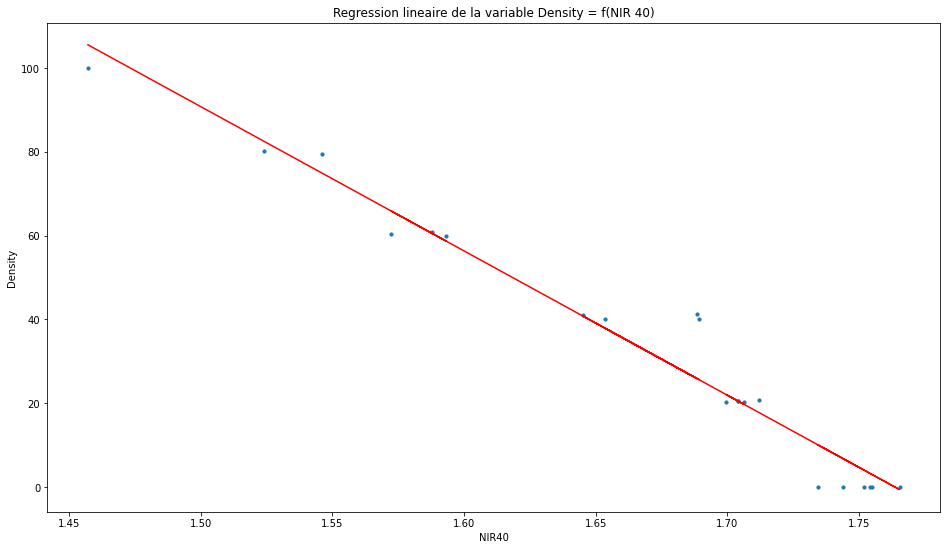

In [12]:
# Tracée des valeurs
# Points de données
plt.figure(figsize=(16,9))
plt.scatter(nir_40, density, s=10)
plt.xlabel('NIR40')
plt.ylabel('Density')
plt.title("Regression lineaire de la variable Density = f(NIR 40)")
# Valeurs prédites
plt.plot(nir_40, density_predicted, color='r')
plt.show()

### Résultat de la regression lineaire simple 
Pente :  [-344.13963868]
Ordonnée à l'origine :  [606.97466441]
Racine carrée de l'erreur quadratique moyenne :  34.907256176224166
Sccore R2 :  0.960745375260051 --> 96% de la variance est expliqué par ce modèle



## 3 Selectionner les variables nir.40 et nir.219 et realiser la régression de la variable densit ́e en fonction de ces deux variables. Donnez le coefficient de corr ́elation multiple au carre R2.


In [13]:
nir_219 = x_tereph["NIR.219"].values
nir_40 = x_tereph['NIR.40'].values

In [14]:
# Réalisation de la regression lineaire en utilisant scikit learn
regression_model = LinearRegression()
# centrer les données 
nir = np.column_stack((nir_40,nir_219))
standardscale = StandardScaler()
nir = standardscale.fit_transform(nir)

# Entrainement du modèle 

regression_model.fit(nir,y=density)
# prediction 
density_predicted = regression_model.predict(X=nir)

# Evaluation du modèle 
rmse = mean_squared_error(y_true=density, y_pred= density_predicted)
r2 = r2_score(y_true = density , y_pred= density_predicted)

# Affichage des valeurs
print("Pente : " ,regression_model.coef_)
print("Ordonnée à l'origine : ", regression_model.intercept_)
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print('Sccore R2 : ', r2)


Pente :  [-29.50283785   0.34107411]
Ordonnée à l'origine :  33.620000000000026
Racine carrée de l'erreur quadratique moyenne :  34.86581467867422
Sccore R2 :  0.9607919779041193


#### conclusion 
 Pente :  [-347.36167309    7.36986092]
Ordonnée à l'origine :  607.2158952354965
Racine carrée de l'erreur quadratique moyenne :  34.86581467867437
Sccore R2 :  0.9607919779041192 --> 96% de variance expliqué on peut donc dire que la variable NIR 219 n'a pas apporté d'information supplémentaire 

# PARTIE 2 :  Exercice de comprehension du grain 07

## 1 Description du projet 

Les donnees utilisées ici concernent 187 huiles d’olives dont l’origine géographique est connue. L’objectif de cet exercice est de prédire l’acide linolénique C18-3ω3 en fonction des spectres PIR. Nous utiliserons les fichiers pir.tab et ags.tab.

## 2 Charger les fichiers pir.tab et ags.tab.

In [15]:
### chargement des données
pir = pd.read_csv("data/pir.csv")
ags = pd.read_csv("data/ags.csv")
labels = pd.read_csv("data/labels2.csv")

In [16]:
ags.head()

,Unnamed: 0,C16:0,C16:1w9,C16:1w7,C17:0,C17:1w8,C18:0,C18:1w9,C18:1w7,C18:2w6,C18:3w3,C20:0,C20:1w9,C22:0,C24:0,Squalene
0,AP01,13.22,0.10,1.01,0.06,0.11,2.03,71.06,2.61,8.37,0.69,0.34,0.24,0.11,0.05,0.65
1,AP02,14.32,0.12,1.06,0.09,0.16,2.34,67.34,2.51,10.74,0.55,0.38,0.22,0.11,0.05,0.59
2,AP03,14.00,0.12,1.06,0.10,0.17,2.24,68.13,2.56,10.33,0.56,0.36,0.21,0.11,0.05,0.62
3,AP04,13.84,0.11,0.90,0.08,0.14,2.38,67.67,2.29,11.28,0.57,0.37,0.20,0.11,0.06,0.58
4,AP05,13.69,0.12,1.03,0.12,0.21,2.40,68.92,2.51,9.69,0.55,0.38,0.21,0.12,0.05,0.60


In [17]:
pir.head()

,,1000,1002,1004,1006,1008,1010,1012,1014,1016,...,2204,2206,2208,2210,2212,2214,2216,2218,2220,2222
0,AP01,-0.048440,-0.048092,-0.047316,-0.046144,-0.045150,-0.043572,-0.042092,-0.040565,-0.040039,...,0.20674,0.20972,0.21389,0.21894,0.22447,0.23109,0.23900,0.24760,0.25572,0.26319
1,AP02,-0.039741,-0.039632,-0.039018,-0.037626,-0.036367,-0.035787,-0.034085,-0.032902,-0.031115,...,0.20709,0.20969,0.21348,0.21798,0.22370,0.23022,0.23842,0.24706,0.25568,0.26325
2,AP03,-0.044596,-0.044075,-0.043265,-0.042641,-0.041595,-0.039918,-0.038797,-0.036772,-0.035691,...,0.21084,0.21384,0.21781,0.22274,0.22816,0.23511,0.24303,0.25140,0.25961,0.26728
3,AP04,-0.046453,-0.046504,-0.045753,-0.044264,-0.043697,-0.042527,-0.041353,-0.039224,-0.038729,...,0.20320,0.20600,0.20954,0.21416,0.21955,0.22650,0.23430,0.24307,0.25165,0.25970
4,AP05,-0.047020,-0.046133,-0.044943,-0.044525,-0.043642,-0.041699,-0.040246,-0.039083,-0.037985,...,0.21023,0.21331,0.21699,0.22182,0.22742,0.23409,0.24198,0.25043,0.25854,0.26626


In [18]:
labels.head()

,,code1,code2
0,AP01,1,AP
1,AP02,1,AP
2,AP03,1,AP
3,AP04,1,AP
4,AP05,1,AP


In [19]:
# recuperer les classes origines :
classe = labels["code2"].values

In [20]:
# recuperer la valeur à predire ou à expliquer
c18_3w3 = ags['C18:3w3'].values

In [21]:
# recuperez  les valeurs spectrales comme intensities wavelength  
wavelength = pir.drop('  ',axis=1)
wavelength =  np.array(wavelength.columns, dtype=float)
intensities = pir.drop('  ',axis=1)
intensities = intensities.values

## 3 Selectionner 10 longueurs d’ondes

Les 10 longueurs d'ondes à utiliser sont données en indices dans l'exercice : 1000, 1124, 1248, 1372, 1496, 1620, 1744, 1868, 1992 et 2116nm

In [22]:
# recuperons les indices suivantes
indices = np.where(np.in1d(wavelength, [1000, 1124, 1248, 1372, 1496, 1620, 1744, 1868, 1992 ,2116]))

intensities_filtered = intensities[:,indices[0]]
intensities_filtered.shape


(187, 10)

## 4 Quel est le nombre d’observations ? de variables explicatives ?
nombre d’observations : 187
Variable explicatives : 10
(187, 1, 10)

## 5 Realisez la régression multiple de la variable linoleique en fonction des 10 longueurs d’ondes sélectionnées. Donnez le coefficient de corrélation multiple.

In [23]:
# Réalisation de la regression lineaire en utilisant scikit learn
regression_model = LinearRegression()
# centrer les données 
standardscale = StandardScaler()
intensities_filtered = standardscale.fit_transform(intensities_filtered)

# Entrainement du modèle 

regression_model.fit(intensities_filtered,y=c18_3w3)
# prediction 
c18_3w3_predicted = regression_model.predict(X=intensities_filtered)

# Evaluation du modèle 
rmse =np.sqrt(mean_squared_error(y_true=c18_3w3, y_pred= c18_3w3_predicted))
r2 = r2_score(y_true=c18_3w3, y_pred= c18_3w3_predicted)
r = np.sqrt(r2)
# Affichage des valeurs
print("Pente : " ,regression_model.coef_)
print("Ordonnée à l'origine : ", regression_model.intercept_)
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print('Sccore R2 : ', r2)
print('Coefficient de correlation : ', r)

Pente :  [-0.00686456 -0.10227075 -0.02874403  0.0824108   0.37881812 -0.29186662
 -0.12806555  0.02258288  0.02934634  0.01614267]
Ordonnée à l'origine :  0.595080213903742
Racine carrée de l'erreur quadratique moyenne :  0.06211001985619149
Sccore R2 :  0.46614712306623374
Coefficient de correlation :  0.6827496781883048


### Resultat
Pente :  [[  -1.66740451  -27.78796939   -8.48065889   26.2202775   126.95634869
  -101.71606155  -46.6704157     8.03716696   10.86459233    6.26973814]]
Ordonnée à l'origine :  [17.10534109]
Racine carrée de l'erreur quadratique moyenne :  0.06211001985619129
Sccore R2 :  0.4661471230662373 --> modèle pas interessant (est ce que les longueurs d'ondes choisis sont les bonnes ? on saura pas vu que cela fut indiqués)
Coefficient de correlation :  0.6827496781883073



## 6 Realisez un premier graphique representant les residus sur les y contre les valeurs prédites, et un second graphique representant le qq-plot des résidus.


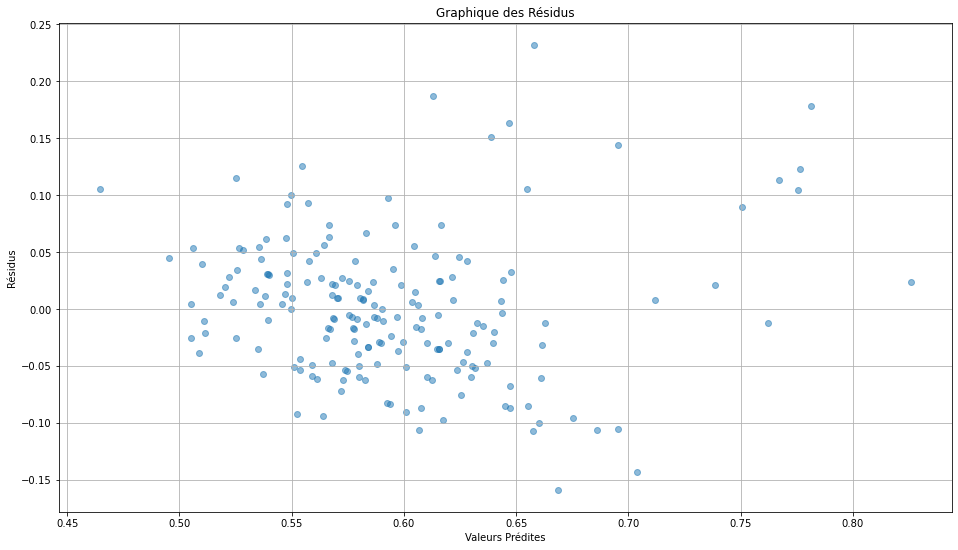

In [24]:
# Calcul des résidus
residuals = c18_3w3 - c18_3w3_predicted

# Créez un graphique de dispersion des résidus par rapport aux valeurs prédites
plt.figure(figsize=(16, 9))
plt.scatter(c18_3w3_predicted, residuals, alpha=0.5)
plt.xlabel('Valeurs Prédites')
plt.ylabel('Résidus')
plt.title('Graphique des Résidus')
plt.grid(True)

# Affichez le graphique
plt.show()

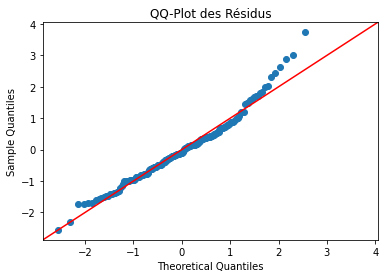

In [25]:
# Créez un QQ-plot pour comparer les résidus à une distribution normale
sm.qqplot(residuals, line='45', fit=True ) # line (45 ou q à bookiner encore )

# Personnalisez le graphique
plt.title('QQ-Plot des Résidus')

# Affichez le graphique
plt.show()

### Conclusion 

- Graphique des Résidus : les résidus augmentent plus la valeur prédites augmente alors elle n'est pas aléatoire (donc le modèle n'est pas bon ) de plus ils sont pas aléatoirement répartis autour de 0.
- QQ-plot des résidus : Le qqplot permet d'évaluer la normalité des residus on observe que les résidus s'écartent peu à peu de la normalité 

## 7 Rajouter les labels de l’origine geographique sur le graphique des residus - valeurs predites le premier graphique de la figure precedente). Que pensez-vous de ce modele ?

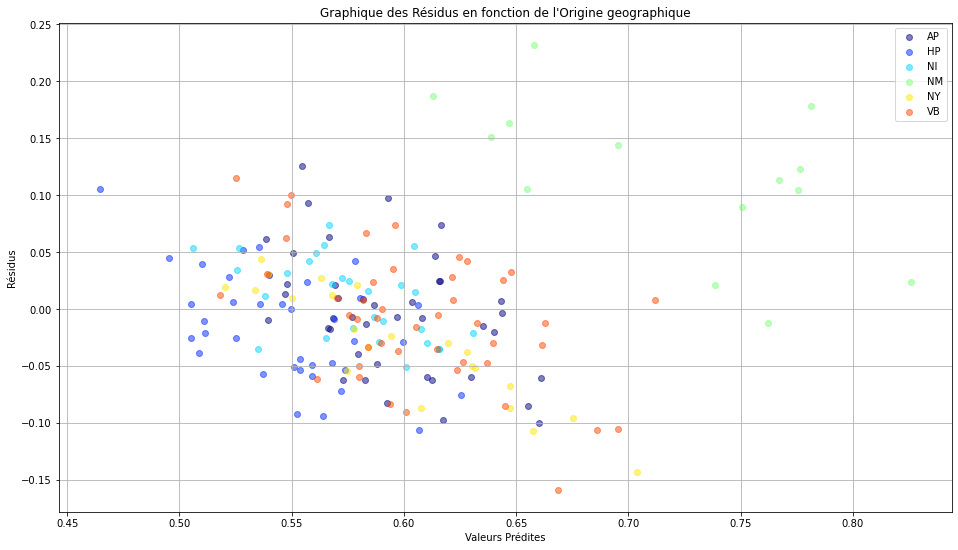

In [26]:
# Supposons que vous avez un tableau de classes appelé 'classes'
unique_classes = np.unique(classe)

# Créez un dictionnaire de couleurs en générant automatiquement des couleurs uniques
class_colors = {cls: plt.cm.jet(i / float(len(unique_classes))) for i, cls in enumerate(unique_classes)}

plt.figure(figsize=(16, 9))
for cls in unique_classes:
    mask = (classe == cls)
    plt.scatter(c18_3w3_predicted[mask], residuals[mask], label=cls, color=class_colors[cls], alpha=0.5)

plt.xlabel('Valeurs Prédites')
plt.ylabel('Résidus')
plt.title("Graphique des Résidus en fonction de l'Origine geographique")
plt.grid(True)
plt.legend()

# Affichez le graphique
plt.show()

### Observation 
La repartion des résidus en fonction de l'origine montre bien que les huiles de NM nimes se demarques des autres. Ainsi le modèle semble dependre des origines de l'huile


# FIN 